In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import numpy as np
import pandas as pd
import datetime

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Input, Layer, BatchNormalization, Bidirectional, TextVectorization
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# set Randomseed
RSEED = 42

# import needed functions
from scripts.processing import *

# Load the TensorBoard notebook extension
%load_ext tensorboard

2.9.2


In [2]:
# The maximum number of words to be used. (most frequent)
# TODO enlarge for larger datasets
VOCAB_SIZE = 100000

# Dimension of the dense embedding.
EMBEDDING_DIM = 128

# Max number of words in each review.
MAX_LENGTH = 200

# Define start and end index (end not included) of dataset
# DFR_START = None
DFR_END = 524288

# Define ANN hyperparameter
EPOCHS = 2
BATCH_SIZE = 512

In [3]:
# load the dataset and use specified dataset
# TODO change dfr to dataset when csv clean
dfr = pd.read_csv('../data/yelp_dataset/review_1819_preprocessed_final.csv')
# dfr = dfr[DFR_START:DFR_END]

In [4]:
# reduce dataset to text and rating
# TODO drop drop when csv clean
dataset = dfr.drop('Unnamed: 0', axis=1)
dataset = dataset.sample(DFR_END, random_state=RSEED)

# check dataset
dataset.head()

,text,useful
1493338,Awesome burgers the bun being an English muffi...,0
1122087,Fairly inexpensive asian food with a variety o...,1
724655,Stopped in for some sushi on a Wednesday night...,1
219475,Honestly Im very disappointed with this place....,1
879117,Okay I maybe the Grinch who stole Christmas bu...,1


In [5]:
# define feature and target
review = dataset[['text']]
# TODO delete apply after changes in csv
# target = dataset["useful"].apply(lambda x: 1 if x > 0 else 0).values
target = dataset["useful"]

In [6]:
# split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(review, target, test_size = 0.20, random_state = RSEED)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(419430, 1) (419430,)
(104858, 1) (104858,)


In [7]:
# initialize vectorizer
vectorize_layer = TextVectorization(
 standardize='lower_and_strip_punctuation', 
 ngrams=3,
 max_tokens=VOCAB_SIZE,
 output_mode='int',
 output_sequence_length=MAX_LENGTH)

# fit vectorizer
vectorize_layer.adapt(X_train)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-09-07 21:27:41.241732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-07 21:27:41.242141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-07 21:27:41.678455: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-07 21:27:41.796341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [8]:
# SOURCE: https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [9]:
# build model architecture
# TODO comment
text_in = Input(shape=(1,), dtype=tf.string)
vector = vectorize_layer(text_in)
embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(vector)
text_bidir_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(embedding)
text_dropout_1 = Dropout(0.5)(text_bidir_lstm_1)
text_bidir_lstm_2 = Bidirectional(LSTM(128))(text_dropout_1)
text_dropout_2 = Dropout(0.5)(text_bidir_lstm_2)
text_dense = Dense(64, activation='relu')(text_dropout_2)
text_out = Dropout(0.5)(text_dense)

dense_1 = Dense(128, activation='relu')(text_out)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)

out = Dense(1, activation='sigmoid')(dropout_2)
model = Model(inputs=[text_in], outputs=[out])

In [10]:
#compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# save history in tensorboard
# TODO get tensorboard working again
log_dir = "../logs/new/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create a callback that saves the model's weights
# TODO save several checkpoints
checkpoint_path = "../training/model_extended_3_no_attention/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [12]:
# set parameters and train the model
history = model.fit(X_train, y_train, shuffle=True ,
                    epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_split=0.2,
                    callbacks=[cp_callback])

model.save('../saved_model/model_extended_3_no_attention')

Epoch 1/2


2022-09-07 21:30:20.130902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:30:20.866075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:30:20.884011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:30:21.963309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:30:22.140178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:30:24.967246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:30:25.024005: I tensorflow/core/grappler/optimizers/cust

656/656 [==============================] - ETA: 0s - loss: 0.6408 - accuracy: 0.6311

2022-09-07 21:59:00.920557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:59:01.242386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:59:01.294834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:59:02.517853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 21:59:02.781944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to ../training/model_extended_3_no_attention/cp.ckpt
656/656 [==============================] - 1850s 3s/step - loss: 0.6408 - accuracy: 0.6311 - val_loss: 0.6267 - val_accuracy: 0.6535
Epoch 2/2
656/656 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.6775
Epoch 2: saving model to ../training/model_extended_3_no_attention/cp.ckpt
656/656 [==============================] - 1880s 3s/step - loss: 0.6085 - accuracy: 0.6775 - val_loss: 0.6365 - val_accuracy: 0.6469


INFO:tensorflow:Assets written to: ../saved_model/model_extended_3_no_attention/assets


INFO:tensorflow:Assets written to: ../saved_model/model_extended_3_no_attention/assets


In [13]:
# predict on test set
y_pred = (model.predict(X_test) > 0.5).astype('int32')

2022-09-07 22:33:03.781027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 22:33:04.570462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 22:33:04.629021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 22:33:05.906623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-07 22:33:05.921537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3277/3277 [==============================] - 396s 120ms/step


              precision    recall  f1-score   support

           0       0.67      0.69      0.68     62397
           1       0.52      0.50      0.51     42461

    accuracy                           0.61    104858
   macro avg       0.60      0.60      0.60    104858
weighted avg       0.61      0.61      0.61    104858



<AxesSubplot:>

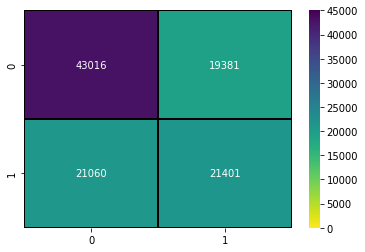

In [14]:
# show the classification report
print(classification_report(y_test, y_pred))

# show confusion matrix
sns.heatmap(tf.math.confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='viridis_r', linewidth=0.01, linecolor='k', vmin=0, vmax=45000)

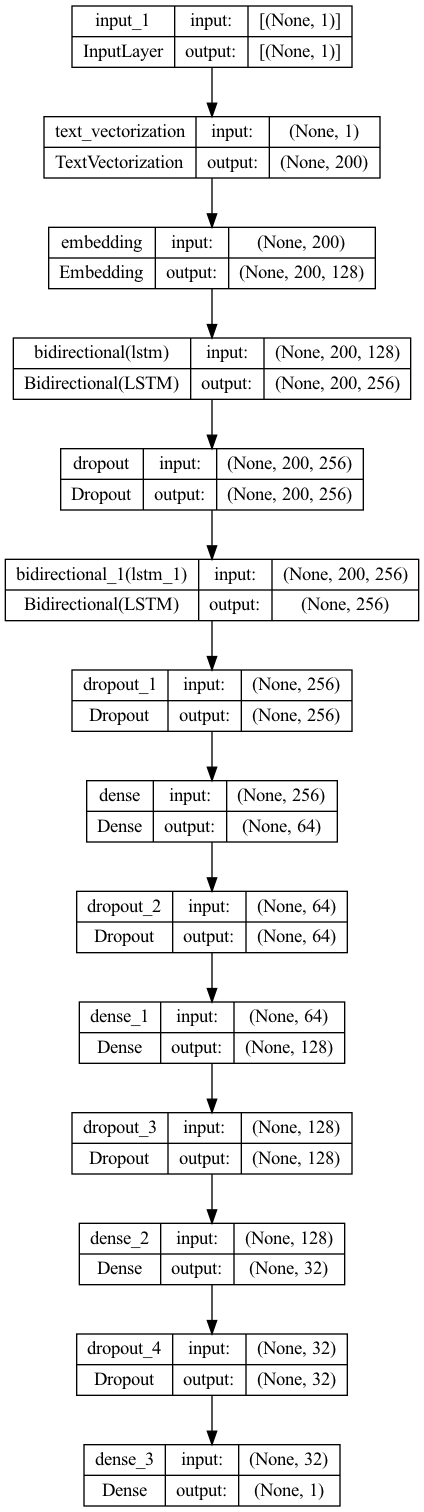

In [15]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model_2.png", show_shapes=True)